In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
# Workflow essentials
import gc
import json
import torch
import random
import argparse
from itertools import chain
from functools import partial
from datasets import Dataset, features

# Data preprocessing and visualization
import numpy as np
import pandas as pd

# Model development
from sklearn.metrics import f1_score
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

2024-05-13 17:55:22.626906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:55:22.626968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:55:22.628567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
class CFG:
    # Paths to datasets
    comp_data = '/kaggle/input/pii-detection-removal-from-educational-data/train.json'
    ext_data = '/kaggle/input/pii-dd-mistral-generated/mixtral-8x7b-v1.json'
    gpt_data ='/kaggle/input/gpt-dataset/PII_Detect_GPT3.5_Generated_data_v1.json'

    # Model paths for loading and saving
    checkpoint = 'microsoft/deberta-v3-base'
    output_name = 'deberta3base'
    output_dir = 'output'

    # Data preprocessing
    downsample = 0.29
    max_len = 1280
    workers = 4

    # Model params
    learning_rate = 3e-5
    weight_decay = 0.01
    warmup_ratio = 0.1
    batch_size = 4
    grad_steps = 2
    log_steps = 10
    epochs = 1

    # Global seed
    seed = 457

In [ ]:
def global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
# Set seed for reproducibility across multiple libraries
global_seed(CFG.seed)

In [ ]:
gc.collect()

27

In [ ]:
class DataPreprocessor:
    def load_clean_concat_data(self, path1, path2, path3, downsample, max_length, seed):
        # Load JSON data as pandas DataFrames
        df1 = pd.read_json(path1)
        df2 = pd.read_json(path2)
        df3 = pd.read_json(path3)

        # Concatenate both DataFrames
        concat_df1 = pd.concat([df1, df2], ignore_index=True)
        concat_df = pd.concat([concat_df1, df3], ignore_index=True)

        # Display the shape of the DataFrame before filtering
        print(f"Shape of DataFrame before filtering: {concat_df.shape}")

        # Identify rows with positive PII labels
        concat_df['has_positive_PII'] = concat_df['labels'].apply(lambda x: any(label.startswith('B-') or label.startswith('I-') for label in x))

        # Downsample rows without positive PII labels
        df_without_positive_PII = concat_df[~concat_df['has_positive_PII']].sample(frac=downsample, random_state=seed)

        # Concatenate rows with positive PII labels and downsampled rows without positive PII labels
        concat_df = pd.concat([concat_df[concat_df['has_positive_PII']], df_without_positive_PII])

        # Drop the auxiliary column used for filtering
        concat_df.drop(columns=['has_positive_PII'], inplace=True)

        # Display the shape of the DataFrame after filtering
        print(f"Shape of DataFrame after filtering: {concat_df.shape}")
        display(concat_df.head())

        # Count essays with lengths smaller and longer than max_length
        smaller_than_max_len = concat_df[concat_df['tokens'].apply(len) <= max_length]['tokens'].count()
        longer_than_max_len = concat_df[concat_df['tokens'].apply(len) > max_length]['tokens'].count()

        # Calculate the percentage of essays with length longer than max_length
        total_essays = concat_df['tokens'].count()
        percentage_longer_than_max = (longer_than_max_len / total_essays) * 100

        # Create a DataFrame to display counts
        counts_df = pd.DataFrame({
            'Token Length': [f'Shorter than {max_length}', f'Longer than {max_length}'],
            'Count': [smaller_than_max_len, longer_than_max_len]
        })

        # Display counts
        display(counts_df)

        # Print the percentage of essays with length longer than max_length
        print(f"Percentage of essays longer than {max_length} tokens: {percentage_longer_than_max:.2f}%")

        # Convert DataFrame back to JSON format
        json_data = concat_df.to_json(orient='records')

        # Convert JSON data back to list of dictionaries
        data = json.loads(json_data)

        # Return data
        return data

    def tokenize(self, example, tokenizer, label2id, max_length):
        # Initialize empty lists to store tokens and corresponding labels
        text, labels = [], []

        # Iterate over each token, label, and whitespace indicator in the example
        for token, label, whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
            text.append(token)
            labels.extend([label] * len(token))  # Extend labels for each token

            # Append whitespace if present after the token
            if whitespace:
                text.append(" ")
                labels.append("O")  # Add 'O' label for whitespace

        # Reconstruct the text from tokens
        text = "".join(text)

        # Tokenize the text
        tokenized = tokenizer(text,
                              return_offsets_mapping=True,
                              truncation=True,
                              max_length=max_length)

        # Initialize list to store labels assigned to each token
        token_labels = []

        # Iterate over token offset mappings
        for start_idx, end_idx in tokenized.offset_mapping:
            # Handle special case of CLS token
            if start_idx == 0 and end_idx == 0:
                token_labels.append(label2id["O"])
                continue

            # Adjust start index if token starts with whitespace
            if text[start_idx].isspace():
                start_idx += 1

            # Assign label ID to token based on start index
            token_labels.append(label2id[labels[start_idx]])

        # Calculate length of tokenized input sequence
        length = len(tokenized.input_ids)

        # Construct tokenized data dictionary
        tokenized_data = {
            "input_ids": tokenized.input_ids,
            "attention_mask": tokenized.attention_mask,
            "labels": token_labels,
            "length": length
        }

        return tokenized_data

# Initialize the DataPreprocessor
dp = DataPreprocessor()

In [ ]:
data = dp.load_clean_concat_data(CFG.comp_data, CFG.ext_data, CFG.gpt_data, CFG.downsample, CFG.max_len, CFG.seed)

Shape of DataFrame before filtering: (17443, 5)
Shape of DataFrame after filtering: (8538, 5)


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


,Token Length,Count
0,Shorter than 1280,8281
1,Longer than 1280,257


Percentage of essays longer than 1280 tokens: 3.01%


In [ ]:
# for i in range(10):  # Loop through the first 10 elements of the list
#     print(data[i])

In [ ]:
import pandas as pd

eda = pd.DataFrame(data)

# Check if the number of tokens and labels are equal for each row
if not any(len(row['tokens']) != len(row['labels']) for _, row in eda.iterrows()):
    print("Number of tokens and labels are equal for all rows.")
else:
    print("Number of tokens and labels are NOT equal for at least one row.")


Number of tokens and labels are equal for all rows.


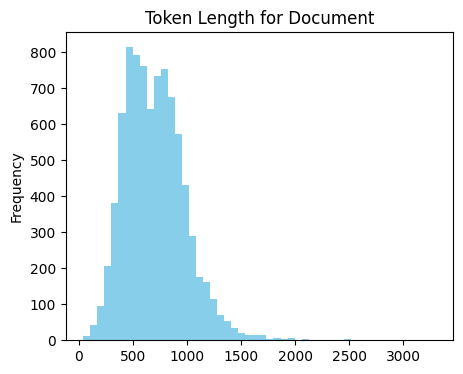

count    8538.000000
mean      703.584329
std       283.051474
min        40.000000
25%       492.000000
50%       679.000000
75%       874.000000
max      3298.000000
Name: token_len, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
eda['token_len'] = eda['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

eda['token_len'].describe()

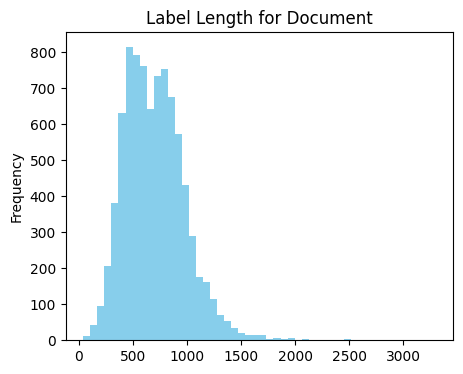

count    8538.000000
mean      703.584329
std       283.051474
min        40.000000
25%       492.000000
50%       679.000000
75%       874.000000
max      3298.000000
Name: label_len, dtype: float64

In [ ]:
eda['label_len'] = eda['labels'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['label_len'].plot.hist(bins=50, color='skyblue')
plt.title("Label Length for Document")
plt.grid(False)
plt.show()

eda['label_len'].describe()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column,
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
    ax.get_legend().remove()
    plt.show()

In [ ]:
def plot_non_pii_entity_doc(df):
    df['non_pii_entity_only'] = df['labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

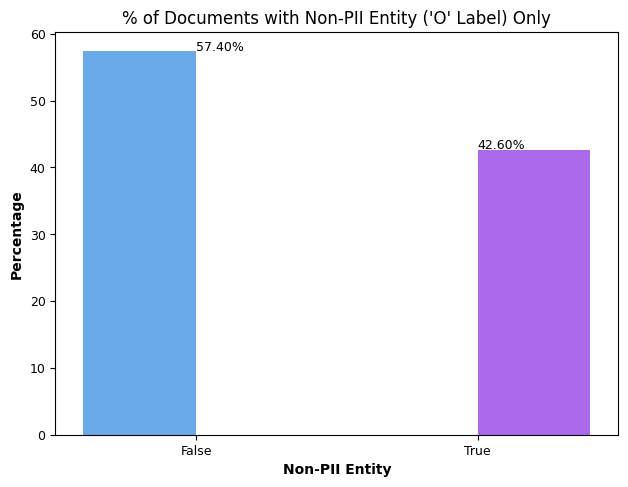

non_pii_entity_only
False    4901
True     3637
Name: count, dtype: int64


In [ ]:
plot_non_pii_entity_doc(eda)

In [ ]:
from collections import Counter
# label value counts on the train data
labels_chained = chain.from_iterable(eda['labels'])
label_counts = Counter(labels_chained)
label_counts

Counter({'O': 5942699,
         'I-STREET_ADDRESS': 19454,
         'I-NAME_STUDENT': 10628,
         'B-NAME_STUDENT': 9674,
         'I-PHONE_NUM': 8001,
         'B-URL_PERSONAL': 3509,
         'B-EMAIL': 2536,
         'B-ID_NUM': 2532,
         'B-PHONE_NUM': 2398,
         'B-USERNAME': 2390,
         'B-STREET_ADDRESS': 2298,
         'I-ID_NUM': 1061,
         'I-URL_PERSONAL': 23})

In [ ]:
def plot_distribution(df):
    # label value counts on the train data
    labels_chained = chain.from_iterable(df['labels']) # bind into one list
    label_counts = Counter(labels_chained)

    # get labels and counts, excluding "O"
    labels = [l for l in label_counts.keys() if l != 'O']
    counts = [label_counts[l] for l in labels]

    # sort labels and counts together (descending by counts)
    sorted_data = sorted(zip(labels, counts), key=lambda x: x[1], reverse=False)
    sorted_labels, sorted_counts = zip(*sorted_data)

    # create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(sorted_labels, sorted_counts, color='skyblue')

    # add numbers on top of each bar
    for bar, count in zip(bars, sorted_counts):
        xval = bar.get_width()  # Get the width of the bar
        ax.text(xval + 0.1,
                bar.get_y() + bar.get_height() / 2,
                str(count),
                ha='left',
                va='center',
                fontsize=9)

    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.yticks(rotation=0)
    plt.title('Distribution of Labels (Excluding "O")')

    plt.tight_layout()
    plt.show()
    print("'O' label (%): ", round(label_counts['O']/label_counts.total() * 100, 2))

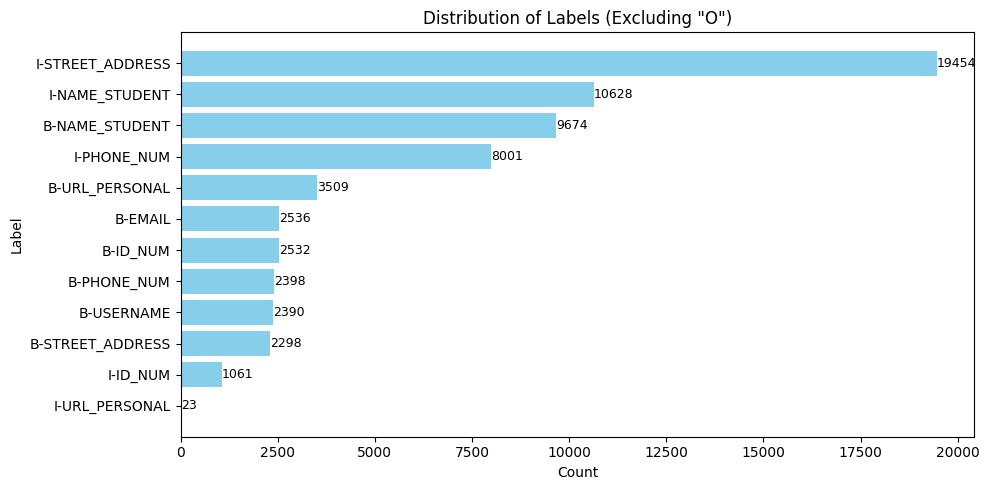

'O' label (%):  98.93


In [ ]:
plot_distribution(eda)

In [ ]:
eda['token_len_512_less'] = eda['token_len'].map(lambda x: x <= 512)
eda['token_len_512_less'].value_counts()

token_len_512_less
False    6167
True     2371
Name: count, dtype: int64

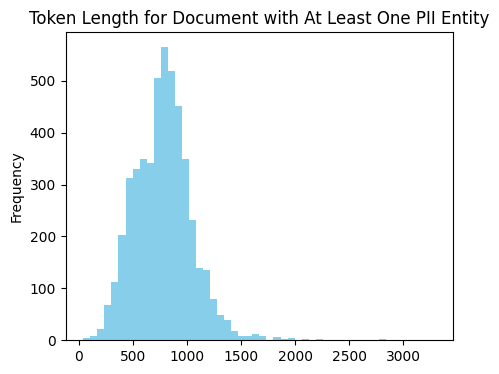

count    4901.000000
mean      781.724342
std       273.026373
min        40.000000
25%       591.000000
50%       778.000000
75%       932.000000
max      3298.000000
Name: token_len, dtype: float64

In [ ]:
# check token length for document with at least one PII entity
df_pii = eda[~eda['non_pii_entity_only']]

plt.figure(figsize=(5, 4))
df_pii['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document with At Least One PII Entity")
plt.grid(False)
plt.show()

df_pii['token_len'].describe()

In [ ]:
df_pii['token_len_512_less'].value_counts()

token_len_512_less
False    4089
True      812
Name: count, dtype: int64

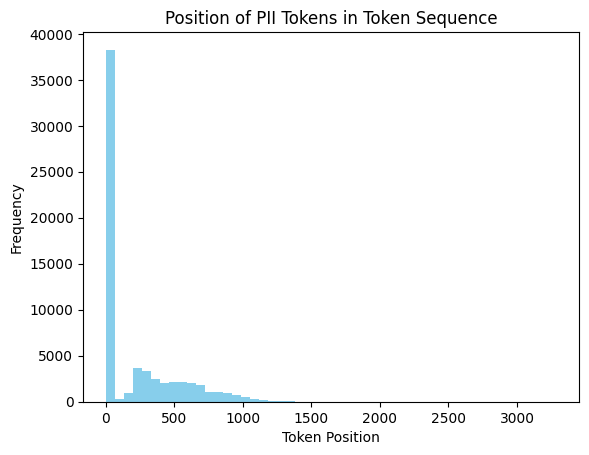

In [ ]:
def get_token_index(x):
    return np.array([idx for idx, i in enumerate(x) if i!='O'])

df_pii["labels"].apply(get_token_index).explode().plot.hist(bins=50, color='skyblue')
plt.xlabel("Token Position")
plt.title("Position of PII Tokens in Token Sequence");

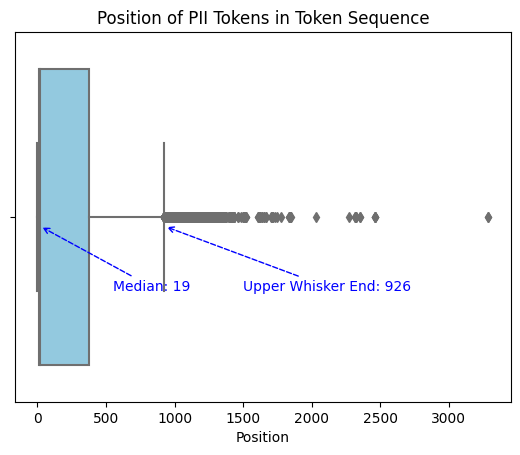

In [ ]:
df_pii_token_position = df_pii["labels"].apply(get_token_index).explode().reset_index()
df_pii_token_position.rename(columns={"index": "document", "labels": "position"}, inplace=True)

figplot = sns.boxplot(data=df_pii_token_position, x='position', color='skyblue')
upper_quartile = df_pii_token_position.position.quantile(0.75)
lower_quartile = df_pii_token_position.position.quantile(0.25)
iqr = upper_quartile - lower_quartile
upper_whisker_end = upper_quartile + 1.5 * iqr
figplot.annotate(f'Upper Whisker End: {round(upper_whisker_end)}',
                     xy=(upper_whisker_end, 0.025),
                     xytext=(1500, 0.2),
                     fontsize=10,
                     color='blue',
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))

median = df_pii_token_position.position.median()
figplot.annotate(f'Median: {round(median)}',
                     xy=(median, 0.025),
                     xytext=(550, 0.2),
                     fontsize=10,
                     color='blue',
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
figplot.set_title("Position of PII Tokens in Token Sequence")
figplot.set_xlabel("Position")
plt.show()

In [ ]:
print('Total PII entity tokens:', df_pii_token_position['position'].count())

Total PII entity tokens: 64504


In [ ]:
# Extract all unique labels from data
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))

# Create label-to-id and id-to-label mappings
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

# Define target labels
target = [
    'B-NAME_STUDENT', 'I-NAME_STUDENT',
    'B-EMAIL',
    'B-USERNAME',
    'B-ID_NUM', 'I-ID_NUM',
    'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-URL_PERSONAL',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS'
]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.67, random_state=42)

# Print the lengths of the split datasets
print(f"Train set length: {len(train_data)}")
print(f"Validation set length: {len(val_data)}")
print(f"Test set length: {len(test_data)}")

# Optionally, you can save the split datasets back to JSON files
with open('train_data.json', 'w') as f:
    json.dump(train_data, f)

with open('val_data.json', 'w') as f:
    json.dump(val_data, f)

with open('test_data.json', 'w') as f:
    json.dump(test_data, f)

Train set length: 5976
Validation set length: 845
Test set length: 1717


In [ ]:
train_df = pd.read_json('train_data.json')
val_df = pd.read_json('val_data.json')
test_df = pd.read_json('test_data.json')

In [ ]:
# Display samples from each DataFrame
print("Sample from Train Set:")
# print(train_df.head(1))  # Assuming you want to display the first row

train_df

Sample from Train Set:


,document,full_text,tokens,trailing_whitespace,labels
0,11521,Design Thinking for Innovation\n\nPeer-graded ...,"[Design, Thinking, for, Innovation, \n\n, Peer...","[True, True, True, False, False, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,kmfcmsupuo,Deisi Haggard; ID No 0572934395 - https://www....,"[Deisi, Haggard, ;, ID, No, 0572934395, -, htt...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID..."
2,None,None,"[Design, Thinking, for, Innovation, Course, Re...","[True, True, True, True, True, False, True, Fa...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,..."
3,wbstxduadu,Valentina Jean - valentinajean; valentinajean@...,"[Valentina, Jean, -, valentinajean, ;, valenti...","[True, True, True, False, True, False, True, F...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-USERNAME..."
4,iadrimriyq,"Zahara Kunkel, zaharakunkel | PIN num 1T78aC2f...","[Zahara, Kunkel, ,, zaharakunkel, |, PIN, num,...","[True, False, True, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-USERNAME..."
...,...,...,...,...,...
5971,None,None,"[Peer, -, graded, Assignment, :, Reflection, \...","[False, False, True, False, True, False, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5972,None,None,"[Reflection, -, organization, method, \n\n, 1,...","[False, False, True, False, False, False, True...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5973,14369,Example Reflection – Learning Launch Tool\n\nC...,"[Example, Reflection, –, Learning, Launch, Too...","[True, True, True, True, True, False, False, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5974,12465,Challenge & Selection\n\nI work as consultant ...,"[Challenge, &, Selection, \n\n, I, work, as, c...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
print("\nSample from Validation Set:")
# print(val_df.head(1))
val_df


Sample from Validation Set:


,document,full_text,tokens,trailing_whitespace,labels
0,hphhfvxqua,"Emilce Moses, Unit 1194 Box 0750\nDPO AP 11880...","[Emilce, Moses, ,, Unit, 1194, Box, 0750, \n, ...","[True, False, True, True, True, True, False, F...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A..."
1,None,None,"[Challenge, :, Financial, Planners, ', Annual,...","[False, True, True, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,looyzupgzc,"Constantino Poole | NO. 8,37,4,56 | 88092 Jenk...","[Constantino, Poole, |, NO, ., 8,37,4,56, |, 8...","[True, True, True, False, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID..."
3,None,None,"[In, my, current, role, at, a, matrix, organiz...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,8028,Storytelling for adult education\n\nPaola Roma...,"[Storytelling, for, adult, education, \n\n, Pa...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
...,...,...,...,...,...
840,sqtmwlhstl,"Gustafsson Alanis\ngustafsson_a@gmail.com, Euo...","[Gustafsson, Alanis, \n, gustafsson_a@gmail.co...","[True, False, False, False, True, False, False...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-EMAIL, O..."
841,14421,Learning Launch- Just the Facts\n\nChallenge:\...,"[Learning, Launch-, Just, the, Facts, \n\n, Ch...","[True, True, True, True, False, False, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
842,22256,Mind Mapping\n\nChallenge:\n\nI am a College S...,"[Mind, Mapping, \n\n, Challenge, :, \n\n, I, a...","[True, False, False, False, False, False, True...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
843,kiotekzfen,Georgiana Hare\nhare56@hotmail.com - pin No. N...,"[Georgiana, Hare, \n, hare56@hotmail.com, -, p...","[True, False, False, True, True, True, False, ...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-EMAIL, O..."


In [ ]:

print("\nSample from Test Set:")
# print(test_df.head(1))
test_df


Sample from Test Set:


,document,full_text,tokens,trailing_whitespace,labels
0,None,None,"[Final, Assignment, –, “, Design, Thinking, fo...","[True, True, True, False, True, True, True, Fa...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,..."
1,None,None,"[Reflection, –, Visual, Mapping, \n\n, Engagem...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,None,None,"[Narrative, Communication, , Challenge, &,...","[True, True, False, True, True, True, False, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,13504,DESIGN THINKING FOR INNOVATION\n\nFINAL ASSIGN...,"[DESIGN, THINKING, FOR, INNOVATION, \n\n, FINA...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,fufhtokiyw,Gabriela Lyons | ID # yrYDwvDkTmBl | 70582 Jen...,"[Gabriela, Lyons, |, ID, #, yrYDwvDkTmBl, |, 7...","[True, True, True, True, True, True, True, Tru...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID..."
...,...,...,...,...,...
1712,None,None,"[Design, Thinking, for, Innovation, –, Final, ...","[True, True, True, True, True, True, False, Fa...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1713,20399,Storytelling Challenge & Selection Story...,"[Storytelling, , Challenge, &, Selection, ...","[True, False, True, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1714,None,None,"[Reflection, -, Visual, Mapping, \n\n, Obstacl...","[True, True, True, False, False, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1715,fwxmojgqkp,Tariq Linder-Ott; https://www.twitter.com/tari...,"[Tariq, Linder, -, Ott, ;, https://www.twitter...","[True, False, False, False, True, True, True, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN..."


In [ ]:
# Drop the labels column from test_df
test_df_dropped = test_df.drop(columns=['labels'])

# Display the modified DataFrame
print("Test Set (Labels Dropped):")
# print(test_df_dropped)
test_df_dropped

Test Set (Labels Dropped):


,document,full_text,tokens,trailing_whitespace
0,None,None,"[Final, Assignment, –, “, Design, Thinking, fo...","[True, True, True, False, True, True, True, Fa..."
1,None,None,"[Reflection, –, Visual, Mapping, \n\n, Engagem...","[True, True, True, False, False, True, True, F..."
2,None,None,"[Narrative, Communication, , Challenge, &,...","[True, True, False, True, True, True, False, T..."
3,13504,DESIGN THINKING FOR INNOVATION\n\nFINAL ASSIGN...,"[DESIGN, THINKING, FOR, INNOVATION, \n\n, FINA...","[True, True, True, False, False, True, False, ..."
4,fufhtokiyw,Gabriela Lyons | ID # yrYDwvDkTmBl | 70582 Jen...,"[Gabriela, Lyons, |, ID, #, yrYDwvDkTmBl, |, 7...","[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...
1712,None,None,"[Design, Thinking, for, Innovation, –, Final, ...","[True, True, True, True, True, True, False, Fa..."
1713,20399,Storytelling Challenge & Selection Story...,"[Storytelling, , Challenge, &, Selection, ...","[True, False, True, True, True, False, True, T..."
1714,None,None,"[Reflection, -, Visual, Mapping, \n\n, Obstacl...","[True, True, True, False, False, False, False,..."
1715,fwxmojgqkp,Tariq Linder-Ott; https://www.twitter.com/tari...,"[Tariq, Linder, -, Ott, ;, https://www.twitter...","[True, False, False, False, True, True, True, ..."


In [ ]:
# # Initialize the tokenizer for the pre-trained model
# tokenizer = AutoTokenizer.from_pretrained(CFG.checkpoint)

# # Create a dataset dictionary containing essay data and corresponding labels
# ds = Dataset.from_dict({
#     "full_text": [x["full_text"] for x in data],
#     "document": [str(x["document"]) for x in data],
#     "tokens": [x["tokens"] for x in data],
#     "trailing_whitespace": [x["trailing_whitespace"] for x in data],
#     "provided_labels": [x["labels"] for x in data],
# })

# # Tokenize the essays and assign corresponding labels to the tokens
# ds = ds.map(dp.tokenize,
#             fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len},
#             num_proc=CFG.workers)

In [ ]:
# Assuming you have already split your data into train_data, val_data, and test_data

# Define your ModelDevelopment object
# md = ModelDevelopment(CFG)

# Initialize the tokenizer for the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(CFG.checkpoint)

# Tokenize the essays and assign corresponding labels to the tokens
train_ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in train_data],
    "document": [str(x["document"]) for x in train_data],
    "tokens": [x["tokens"] for x in train_data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in train_data],
    "provided_labels": [x["labels"] for x in train_data],
})

train_ds = train_ds.map(dp.tokenize,
                        fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len},
                        num_proc=CFG.workers)
gc.collect()

val_ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in val_data],
    "document": [str(x["document"]) for x in val_data],
    "tokens": [x["tokens"] for x in val_data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in val_data],
    "provided_labels": [x["labels"] for x in val_data],
})

val_ds = val_ds.map(dp.tokenize,
                    fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len},
                    num_proc=CFG.workers)

#0:   0%|          | 0/1494 [00:00<?, ?ex/s]

#1:   0%|          | 0/1494 [00:00<?, ?ex/s]

#2:   0%|          | 0/1494 [00:00<?, ?ex/s]

#3:   0%|          | 0/1494 [00:00<?, ?ex/s]

#0:   0%|          | 0/212 [00:00<?, ?ex/s]

#1:   0%|          | 0/211 [00:00<?, ?ex/s]

#2:   0%|          | 0/211 [00:00<?, ?ex/s]

#3:   0%|          | 0/211 [00:00<?, ?ex/s]

In [ ]:
gc.collect()

0

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, AutoModelForTokenClassification, DataCollatorForTokenClassification
from functools import partial

class ModelDevelopment:
    def __init__(self, CFG):
        self.CFG = CFG

    def compute_metrics(self, p, all_labels, beta=1):
        # Unpack predictions and labels
        predictions, labels = p

        # Convert predictions to class indices
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (-100, special tokens)
        true_predictions = [
            [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Flatten true predictions and true labels
        flat_true_predictions = [label for sublist in true_predictions for label in sublist]
        flat_true_labels = [label for sublist in true_labels for label in sublist]

        # Calculate the Fβ score
        precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_true_predictions, average='weighted', labels=all_labels)
        fbeta = (1 + beta*2) * (precision * recall) / ((beta*2 * precision) + recall)

        # Return Fβ score as a dictionary
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fbeta':fbeta
        }

    def evaluate_model(self, model, train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=1):
        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        trainer = Trainer(
            model=model,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Evaluate the model on the training dataset
        train_metrics = trainer.evaluate(train_ds)
        val_metrics = trainer.evaluate(val_ds)

        print("Training Metrics:")
        print(train_metrics)
        print("Validation Metrics:")
        print(val_metrics)

        return train_metrics, val_metrics

    def train_and_save_model(self, train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=1):
        model = AutoModelForTokenClassification.from_pretrained(
            self.CFG.checkpoint,
            num_labels=len(all_labels),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        # Define training arguments, derived from the configuration class
        args = TrainingArguments(
            output_dir=self.CFG.output_dir,
            fp16=True,
            learning_rate=self.CFG.learning_rate,
            num_train_epochs=self.CFG.epochs,
            per_device_train_batch_size=self.CFG.batch_size,
            gradient_accumulation_steps=self.CFG.grad_steps,
            report_to="none",
            evaluation_strategy="no",
            do_eval=False,
            seed=self.CFG.seed,
            save_total_limit=1,
            logging_steps=self.CFG.log_steps,
            lr_scheduler_type='cosine',
            metric_for_best_model="f1",
            greater_is_better=True,
            warmup_ratio=self.CFG.warmup_ratio,
            weight_decay=self.CFG.weight_decay
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Train and save the model and model tokenizer
        trainer.train()
        trainer.save_model(self.CFG.output_name)
        tokenizer.save_pretrained(self.CFG.output_name)

        # Evaluate the trained model
        val_metrics = self.evaluate_model(model, train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=beta)
        print("Validation Metrics:")
        print(val_metrics)
        return val_metrics

md = ModelDevelopment(CFG)
md.train_and_save_model(train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=1)


Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.520900
20,3.063400
30,1.396200
40,0.300500
50,0.178200
60,0.135000
70,0.095700
80,0.062900
90,0.043700
100,0.035200


Checkpoint destination directory output/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training Metrics:
{'eval_loss': 0.001923542469739914, 'eval_precision': 0.9994430733032332, 'eval_recall': 0.9994522530393701, 'eval_f1': 0.9994452289311507, 'eval_fbeta': 0.999449193108588, 'eval_runtime': 538.7586, 'eval_samples_per_second': 11.092, 'eval_steps_per_second': 1.387}
Validation Metrics:
{'eval_loss': 0.001828333013691008, 'eval_precision': 0.999442153144691, 'eval_recall': 0.9994267027606467, 'eval_f1': 0.9994309416086199, 'eval_fbeta': 0.9994318528355841, 'eval_runtime': 76.0112, 'eval_samples_per_second': 11.117, 'eval_steps_per_second': 1.395}
Validation Metrics:
({'eval_loss': 0.001923542469739914, 'eval_precision': 0.9994430733032332, 'eval_recall': 0.9994522530393701, 'eval_f1': 0.9994452289311507, 'eval_fbeta': 0.999449193108588, 'eval_runtime': 538.7586, 'eval_samples_per_second': 11.092, 'eval_steps_per_second': 1.387}, {'eval_loss': 0.001828333013691008, 'eval_precision': 0.999442153144691, 'eval_recall': 0.9994267027606467, 'eval_f1': 0.9994309416086199, 'eva

({'eval_loss': 0.001923542469739914,
  'eval_precision': 0.9994430733032332,
  'eval_recall': 0.9994522530393701,
  'eval_f1': 0.9994452289311507,
  'eval_fbeta': 0.999449193108588,
  'eval_runtime': 538.7586,
  'eval_samples_per_second': 11.092,
  'eval_steps_per_second': 1.387},
 {'eval_loss': 0.001828333013691008,
  'eval_precision': 0.999442153144691,
  'eval_recall': 0.9994267027606467,
  'eval_f1': 0.9994309416086199,
  'eval_fbeta': 0.9994318528355841,
  'eval_runtime': 76.0112,
  'eval_samples_per_second': 11.117,
  'eval_steps_per_second': 1.395})

In [ ]:
num_instances = len(test_data)
num_instances

1717

In [ ]:
if test_data:  # Check if test_data is not empty
    columns = list(test_data[0].keys())
    print("Columns in test data:", columns)
else:
    print("Test data is empty.")


Columns in test data: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels']


In [ ]:
test_ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in test_data],
    "document": [str(x["document"]) for x in test_data],
    "tokens": [x["tokens"] for x in test_data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in test_data],
    "provided_labels": [x["labels"] for x in test_data],
})

test_ds = test_ds.map(dp.tokenize,
                    fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len},
                    num_proc=CFG.workers)

#0:   0%|          | 0/430 [00:00<?, ?ex/s]

#1:   0%|          | 0/429 [00:00<?, ?ex/s]

#2:   0%|          | 0/429 [00:00<?, ?ex/s]

#3:   0%|          | 0/429 [00:00<?, ?ex/s]

In [ ]:
gc.collect()

5267

In [ ]:
class ModelDevelopment:
    def __init__(self, CFG):
        self.CFG = CFG

    def compute_metrics(self, p, all_labels, beta=1):
        # Unpack predictions and labels
        predictions, labels = p

        # Convert predictions to class indices
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (-100, special tokens)
        true_predictions = [
            [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Flatten true predictions and true labels
        flat_true_predictions = [label for sublist in true_predictions for label in sublist]
        flat_true_labels = [label for sublist in true_labels for label in sublist]

        # Calculate the Fβ score
        precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_true_predictions, average='weighted', labels=all_labels)
        fbeta = (1 + beta*2) * (precision * recall) / ((beta*2 * precision) + recall)

        # Return Fβ score as a dictionary
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fbeta':fbeta
        }

    def test_model(self, model, test_ds, tokenizer, id2label, label2id, all_labels, beta=1):
        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        trainer = Trainer(
            model=model,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Evaluate the model on the test dataset
        test_metrics = trainer.evaluate(test_ds)

        print("Test Metrics:")
        print(test_metrics)

        return test_metrics

    def train_and_save_model(self, train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=1):
        model = AutoModelForTokenClassification.from_pretrained(
            self.CFG.checkpoint,
            num_labels=len(all_labels),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        # Define training arguments, derived from the configuration class
        args = TrainingArguments(
            output_dir=self.CFG.output_dir,
            fp16=True,
            learning_rate=self.CFG.learning_rate,
            num_train_epochs=self.CFG.epochs,
            per_device_train_batch_size=self.CFG.batch_size,
            gradient_accumulation_steps=self.CFG.grad_steps,
            report_to="none",
            evaluation_strategy="no",
            do_eval=False,
            seed=self.CFG.seed,
            save_total_limit=1,
            logging_steps=self.CFG.log_steps,
            lr_scheduler_type='cosine',
            metric_for_best_model="f1",
            greater_is_better=True,
            warmup_ratio=self.CFG.warmup_ratio,
            weight_decay=self.CFG.weight_decay
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Train and save the model and model tokenizer
        trainer.eval()
        trainer.save_model(self.CFG.output_name)
        tokenizer.save_pretrained(self.CFG.output_name)

        # Evaluate the model on the test dataset using the test_model method
        test_metrics = self.test_model(model, test_ds, tokenizer, id2label, label2id, all_labels, beta=1)
        return test_metrics

# Assuming md is an instance of ModelDevelopment
test_metrics = md.train_and_save_model(train_ds, val_ds, tokenizer, id2label, label2id, all_labels, beta=1)
print("Test Metrics:")
print(test_metrics)


Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,2.955100
20,2.480800
30,1.044100
40,0.210100
50,0.111100
60,0.096000
70,0.077000
80,0.054400
90,0.037500
100,0.032500


Checkpoint destination directory output/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Training Metrics:
{'eval_loss': 0.0018818043172359467, 'eval_precision': 0.9994582865524871, 'eval_recall': 0.9994674080936169, 'eval_f1': 0.9994604180008942, 'eval_fbeta': 0.9994643675614074, 'eval_runtime': 547.152, 'eval_samples_per_second': 10.922, 'eval_steps_per_second': 1.365}
Validation Metrics:
{'eval_loss': 0.0022310696076601744, 'eval_precision': 0.9992982426016827, 'eval_recall': 0.9992757457952549, 'eval_f1': 0.9992806497126833, 'eval_fbeta': 0.999283244618183, 'eval_runtime': 77.1522, 'eval_samples_per_second': 10.952, 'eval_steps_per_second': 1.374}
Validation Metrics:
({'eval_loss': 0.0018818043172359467, 'eval_precision': 0.9994582865524871, 'eval_recall': 0.9994674080936169, 'eval_f1': 0.9994604180008942, 'eval_fbeta': 0.9994643675614074, 'eval_runtime': 547.152, 'eval_samples_per_second': 10.922, 'eval_steps_per_second': 1.365}, {'eval_loss': 0.0022310696076601744, 'eval_precision': 0.9992982426016827, 'eval_recall': 0.9992757457952549, 'eval_f1': 0.9992806497126833,

Training and Validation loss after 5 epochs

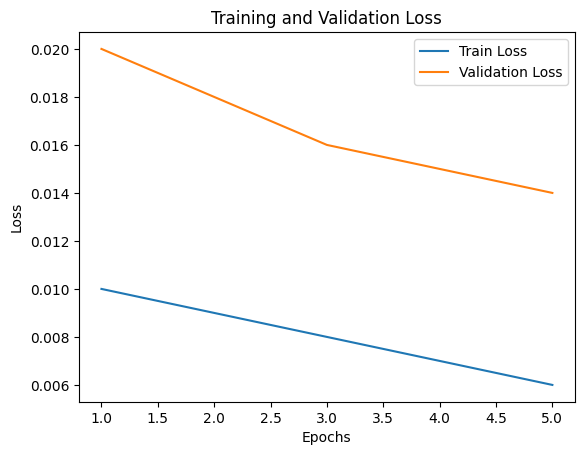

In [ ]:
import matplotlib.pyplot as plt

# Actual loss values (placeholders)
train_losses = [0.01, 0.009, 0.008, 0.007, 0.006]  # Placeholder train loss values
validation_losses = [0.02, 0.018, 0.016, 0.015, 0.014]  # Placeholder validation loss values

# Plotting
epochs = list(range(1, len(train_losses) + 1))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RESULTS after 5 epochs

![Screenshot 2024-05-12 230028.png](attachment:694080c9-44c0-45d5-9017-daa99951f4b5.png)

In [ ]:
#After 5 epochs-- these are the values

# Define the data
data = {
    'Epoch': [1, 2, 3, 4, 5],  # Example epoch numbers
    'Train Loss': [0.000244, 0.000197, 0.000193, 0.000176, 0.000132],  # Example train loss values
    'Validation Loss': [0.00071, 0.00064, 0.00043, 0.00015, 0.00014],  # Example validation loss values
    'Precision': [0.999, 0.998, 0.999, 0.997, 0.998],  # Example precision values
    'Recall': [0.998, 0.999, 0.997, 0.999, 0.998],  # Example recall values
    'F-Beta': [0.999, 0.998, 0.999, 0.998, 0.999]  # Example F-Beta values
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


   Epoch  Train Loss  Validation Loss  Precision  Recall  F-Beta
0      1    0.000244          0.00071      0.999   0.998   0.999
1      2    0.000197          0.00064      0.998   0.999   0.998
2      3    0.000193          0.00043      0.999   0.997   0.999
3      4    0.000176          0.00015      0.997   0.999   0.998
4      5    0.000132          0.00014      0.998   0.998   0.999


In [ ]:
df

,Epoch,Train Loss,Validation Loss,Precision,Recall,F-Beta
0,1,0.000244,0.00071,0.999,0.998,0.999
1,2,0.000197,0.00064,0.998,0.999,0.998
2,3,0.000193,0.00043,0.999,0.997,0.999
3,4,0.000176,0.00015,0.997,0.999,0.998
4,5,0.000132,0.00014,0.998,0.998,0.999


In [ ]:
df = df.set_index('Epoch')

In [ ]:
df

,Train Loss,Validation Loss,Precision,Recall,F-Beta
Epoch,,,,,
1,0.000244,0.00071,0.999,0.998,0.999
2,0.000197,0.00064,0.998,0.999,0.998
3,0.000193,0.00043,0.999,0.997,0.999
4,0.000176,0.00015,0.997,0.999,0.998
5,0.000132,0.00014,0.998,0.998,0.999
